In [113]:
import requests
import pandas as pd
import numpy as np
import io
import datetime
import time
import geopandas as gpd
import os
import contextily as cx
import matplotlib.pyplot as plt

EPSG:3857
EPSG:4326


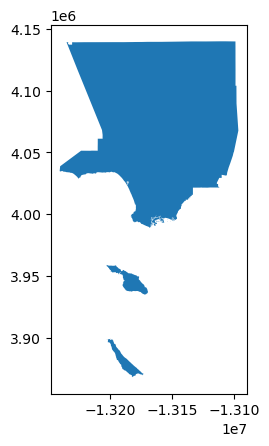

In [5]:
la_county_gdf = gpd.read_file("../Data/LA_County_Boundary/LA_County_Boundary.shp") 
# data retreived from https://geohub.lacity.org/datasets/county-boundary/about 
la_county_gdf.plot()
print(la_county_gdf.crs)
la_county_gdf = la_county_gdf.to_crs(epsg = 4326)
print(la_county_gdf.crs)

In [7]:
minx, miny, maxx, maxy = la_county_gdf.total_bounds
print("LA County Bounding Box in EPSG:4326:")
print(f"MinLon: {minx}, MinLat: {miny}, MaxLon: {maxx}, MaxLat: {maxy}")

LA County Bounding Box in EPSG:4326:
MinLon: -118.94464287431836, MinLat: 32.795205566730765, MaxLon: -117.64638592377494, MaxLat: 34.82330419070888


In [9]:
API_KEY = "XXXX"  
headers = {"X-API-Key": API_KEY}

In [13]:
# =============== 1. 获取 LA bounding box 范围内的传感器列表 ===============
sensors_url = "https://api.purpleair.com/v1/sensors"

NW_LAT, NW_LNG = maxy, minx
SE_LAT, SE_LNG = miny, maxx

fields_list = "name,private,latitude,longitude,hardware,model"
params = {
    "fields": fields_list,
    "nwlat": NW_LAT,
    "nwlng": NW_LNG,
    "selat": SE_LAT,
    "selng": SE_LNG,
    "max_age": 0 
}
resp = requests.get(sensors_url, headers=headers, params=params)
resp.raise_for_status()
sensors_json = resp.json()
sensors_fields = sensors_json["fields"]  # 列名列表
sensors_data = sensors_json["data"]

df_sensors = pd.DataFrame(sensors_data, columns=sensors_fields)
# 仅保留 public 传感器，即 private == 0
df_public = df_sensors[df_sensors["private"] == 0].copy()
public_sensor_indexes = df_public["sensor_index"].unique().tolist()
print(f"Found {len(public_sensor_indexes)} public sensors")
pd.DataFrame(public_sensor_indexes, columns = ['sensor_id']).to_csv('../Data/public_sensor_indexes.csv')

Found 3188 public sensors


In [15]:
# 2. 定义历史数据时间区间、以及用于构造宽表的完整日期序列
history_start = datetime.datetime(2020, 12, 1, 0, 0, 0, tzinfo = datetime.timezone.utc)
history_end   = datetime.datetime(2022, 12, 1, 0, 0, 0, tzinfo = datetime.timezone.utc)
print(int(history_start.timestamp()))
print(int(history_end.timestamp()))

1606780800
1669852800


In [23]:
def get_sensor_history(sensor_index, average, start_dt, end_dt, fields_str):
    base_url = f"https://api.purpleair.com/v1/sensors/{sensor_index}/history"
    params_hist = {
        "start_timestamp": int(start_dt.timestamp()),
        "end_timestamp": int(end_dt.timestamp()),
        "average": average,
        "fields": fields_str,
        "privacy": "public"
    }
    try:
        r = requests.get(base_url, headers=headers, params=params_hist)
        if r.status_code != 200:
            print(f"[Sensor {sensor_index}] failed {r.status_code}: {r.text}")
            return pd.DataFrame()
        js = r.json()
        if not js.get("data"):
            return pd.DataFrame()
        df = pd.DataFrame(js["data"], columns=js["fields"])
        if "time_stamp" in df.columns:
            df["datetime"] = pd.to_datetime(df["time_stamp"], unit="s", utc=True)
            df.set_index("datetime", inplace=True)
        return df
    except Exception as e:
        print(f"[Sensor {sensor_index}] error：{e}")
        return pd.DataFrame()

fields_history = "rssi, uptime, pa_latency, humidity_a, humidity_b, temperature_a, temperature_b, pressure_a, pressure_b, voc_a, voc_b,\
pm2.5_atm_a, pm2.5_atm_b,\
pm10.0_atm_a, pm10.0_atm_b"

In [101]:
# 4. 对每个传感器获取daily 数据 (average=1440)
# 用两个字典分别存储：键为 sensor_index
API_KEY = "XXXX"  
headers = {"X-API-Key": API_KEY}

file_name = "../Data/sensor_daily_data_2021.json"
if os.path.exists(file_name):
    with open(file_name, "r", encoding="utf-8") as f:
        sensor_daily_data = json.load(f)       
else:
    sensor_daily_data = {}

start_index = 0  # If the API call stops, change the index to the previous one.
total = len(public_sensor_indexes)

for i, sensor in enumerate(public_sensor_indexes[start_index:], start=start_index+1):
    print(f"Processing sensor {sensor} ({i}/{total}) ...")
    if str(sensor) in sensor_daily_data:
        print(f"Skip sensor {sensor} ({i}/{total}) — already in file")
        continue
    df_day = get_sensor_history(sensor, average = 1440, start_dt = history_start, end_dt = history_end, fields_str = fields_history)
    daily_by_day = {}
    if not df_day.empty:
        df_day['date'] = df_day.index.date.astype(str)
        for day, subdf in df_day.groupby("date"):
            daily_by_day[day] = subdf.iloc[0].drop("date").to_dict()
    sensor_daily_data[sensor] = daily_by_day

    with open(file_name, "w", encoding = "utf-8") as f:
        json.dump(sensor_daily_data, f, ensure_ascii = False, indent = 4 )
    time.sleep(1)
    print("Data has been saved to", file_name)
    print("--------------------------------------------------")
    

Processing sensor 262161 (1/3188) ...
Skip sensor 262161 (1/3188) — already in file
Processing sensor 262253 (2/3188) ...
Skip sensor 262253 (2/3188) — already in file
Processing sensor 262251 (3/3188) ...
Skip sensor 262251 (3/3188) — already in file
Processing sensor 262261 (4/3188) ...
Skip sensor 262261 (4/3188) — already in file
Processing sensor 262257 (5/3188) ...
Skip sensor 262257 (5/3188) — already in file
Processing sensor 262259 (6/3188) ...
Skip sensor 262259 (6/3188) — already in file
Processing sensor 185 (7/3188) ...
Skip sensor 185 (7/3188) — already in file
Processing sensor 262343 (8/3188) ...
Skip sensor 262343 (8/3188) — already in file
Processing sensor 262437 (9/3188) ...
Skip sensor 262437 (9/3188) — already in file
Processing sensor 302 (10/3188) ...
Skip sensor 302 (10/3188) — already in file
Processing sensor 304 (11/3188) ...
Skip sensor 304 (11/3188) — already in file
Processing sensor 262449 (12/3188) ...
Skip sensor 262449 (12/3188) — already in file
Proc

In [107]:
CSV_PATH = '../Data/public_sensor_indexes.csv'
JSON_PATH = '../Data/sensor_daily_data_2021.json'
ids_df = pd.read_csv(CSV_PATH)
sensor_ids = ids_df["sensor_id"].astype(str).tolist()   # 转成 str 方便和 JSON 的 key 比

# === 3. 读取 JSON 历史数据 =========================================
with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
json_keys = set(data.keys())    # JSON 里的全部 sensor_id（str 类型）

# === 4. 比对 =======================================================
present = [sid for sid in sensor_ids if sid in json_keys]
missing = [sid for sid in sensor_ids if sid not in json_keys]

print(f"Found {len(present)} sensor records, {len(missing)} are missing\n")

# 如果想把缺失的列表打印出来：
if missing:
    print("missing sensor_id：", ", ".join(missing[:20]), "..." if len(missing) > 20 else "")

total_in_json   = len(sensor_daily_data)                      # 你存下来的总条目数
nonempty_sensors = [sid for sid, dd in sensor_daily_data.items()
                    if any(isinstance(r, dict) and r for r in dd.values())]

print("sensor data with records:", len(nonempty_sensors))
print("empty records =", total_in_json - len(nonempty_sensors))

Found 3188 sensor records, 0 are missing

sensor data with records: 1630
empty records = 1558


In [109]:
# 5. 存储daily数据为长表
file_name = "../Data/sensor_daily_data_2021.json"
with open(file_name, "r", encoding="utf-8") as f:
    sensor_daily_data = json.load(f)

records = []
for sensor_id, day_dict in sensor_daily_data.items():
    for date_str, record in day_dict.items():
        # 如果 record 存在且为字典，则生成一行记录
        if isinstance(record, dict) and record:
            row = {"sensor_id": sensor_id, "date": date_str} 
            row.update(record)  # 将 record 中所有字段加入行记录
            records.append(row)
df_long = pd.DataFrame(records)
df_long['date'] = pd.to_datetime(df_long['date'], format="%Y-%m-%d")

# 按 sensor_id 和 date 排序，先转换 sensor_id 为数值类型以便正确排序
df_long.sort_values(by=["sensor_id", "date"], inplace=True)
df_long.reset_index(drop=True, inplace=True)

print(df_long)

       sensor_id       date  time_stamp  rssi     uptime  pa_latency  \
0         100025 2021-02-15  1613347200 -75.0    81801.0         NaN   
1         100025 2021-02-16  1613433600 -70.0    45945.0         NaN   
2         100025 2021-02-17  1613520000 -73.0   117780.0         NaN   
3         100025 2021-02-18  1613606400 -72.0   204180.0         NaN   
4         100025 2021-02-19  1613692800 -72.0   290580.0         NaN   
...          ...        ...         ...   ...        ...         ...   
711630     99423 2022-11-26  1669420800 -60.0  2736306.0       347.0   
711631     99423 2022-11-27  1669507200 -60.0  2822717.0       308.0   
711632     99423 2022-11-28  1669593600 -58.0  2909128.0       316.0   
711633     99423 2022-11-29  1669680000 -60.0  2995509.0       303.0   
711634     99423 2022-11-30  1669766400 -60.0  3081831.0       303.0   

        humidity_a  humidity_b  temperature_a  temperature_b  pressure_a  \
0           36.948         NaN         68.152            Na

# Get sensor information

In [119]:
# 这个输出不能删掉，不能重新运行
LongTable_unique_sensorID = df_long["sensor_id"].unique().tolist()
print(LongTable_unique_sensorID)

['100025', '100111', '100393', '100555', '100635', '100715', '101037', '101059', '101081', '101117', '101125', '101131', '101143', '101183', '101217', '101223', '101309', '101315', '101329', '101333', '101343', '101529', '101533', '101629', '101635', '102018', '102024', '102032', '102042', '102058', '102064', '102466', '102576', '102612', '102644', '102726', '102924', '103066', '103120', '103184', '103198', '103208', '103372', '103374', '103554', '10374', '104344', '104380', '104520', '104544', '104766', '104892', '104900', '104908', '104914', '104916', '104926', '104928', '104940', '104942', '105100', '105298', '10544', '105686', '105814', '105850', '106186', '106394', '106622', '106796', '107072', '107324', '107364', '107468', '107960', '108340', '108518', '108592', '108618', '10874', '108786', '108790', '108792', '108794', '108802', '108814', '10890', '109166', '109168', '109188', '109378', '109380', '109382', '109386', '109390', '109392', '109394', '109404', '109616', '109624', '10

In [121]:
fields2 = (
    "model,location_type,latitude,longitude,altitude,"
    "position_rating,uptime,"
    "date_created,"
    "confidence"
)

API_KEY = "3602E101-1A34-11F0-81BE-42010A80001F"  
headers = {"X-API-Key": API_KEY}

data_list = []
ii = 1
total = len(LongTable_unique_sensorID)
for sensor_id in LongTable_unique_sensorID:  # 测试单个 sensor_id
    print(f"Processing sensor {sensor_id} ({ii}/{total}) ...")
    ii = ii + 1
    url = f"https://api.purpleair.com/v1/sensors/{sensor_id}"
    params = {"fields": fields2}
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        json_data = response.json()
        json_data["sensor"]
        data_list.append(json_data["sensor"])
        
    except Exception as e:
        print(f"Error processing sensor {sensor_id}: {e}")

df = pd.DataFrame(data_list)
df.to_csv('../Data/sensor_info_2021.csv')
df.head(5)

Processing sensor 100025 (1/1630) ...
Processing sensor 100111 (2/1630) ...
Processing sensor 100393 (3/1630) ...
Processing sensor 100555 (4/1630) ...
Processing sensor 100635 (5/1630) ...
Processing sensor 100715 (6/1630) ...
Processing sensor 101037 (7/1630) ...
Processing sensor 101059 (8/1630) ...
Processing sensor 101081 (9/1630) ...
Processing sensor 101117 (10/1630) ...
Processing sensor 101125 (11/1630) ...
Processing sensor 101131 (12/1630) ...
Processing sensor 101143 (13/1630) ...
Processing sensor 101183 (14/1630) ...
Processing sensor 101217 (15/1630) ...
Processing sensor 101223 (16/1630) ...
Processing sensor 101309 (17/1630) ...
Processing sensor 101315 (18/1630) ...
Processing sensor 101329 (19/1630) ...
Processing sensor 101333 (20/1630) ...
Processing sensor 101343 (21/1630) ...
Processing sensor 101529 (22/1630) ...
Processing sensor 101533 (23/1630) ...
Processing sensor 101629 (24/1630) ...
Processing sensor 101635 (25/1630) ...
Processing sensor 102018 (26/1630)

,sensor_index,date_created,location_type,model,uptime,position_rating,latitude,longitude,altitude,confidence
0,100025,1613408980,0,PA-II,24858,5,34.170567,-118.113960,1037.0,100
1,100111,1613762783,0,PA-II-SD,39297,5,34.151573,-118.164360,777.0,100
2,100393,1614626471,1,PA-I,26906,5,34.149754,-118.126670,829.0,30
3,100555,1614712094,1,PA-I,47413,5,33.957664,-118.440630,130.0,30
4,100635,1614714301,0,PA-II-SD,16,5,34.018406,-118.160835,184.0,100


In [123]:
# 6. 合并sensor info到long table上
df_long["sensor_id"] = df_long["sensor_id"].astype(int)
df_final = df_long.merge(df, left_on="sensor_id", right_on="sensor_index", how="left")
df_final.to_csv('../Data/final_table_2021.csv')
df_final.head()

,sensor_id,date,time_stamp,rssi,uptime_x,pa_latency,humidity_a,humidity_b,temperature_a,temperature_b,...,sensor_index,date_created,location_type,model,uptime_y,position_rating,latitude,longitude,altitude,confidence
0,100025,2021-02-15,1613347200,-75.0,81801.0,NaN,36.948,NaN,68.152,NaN,...,100025,1613408980,0,PA-II,24858,5,34.170567,-118.11396,1037.0,100
1,100025,2021-02-16,1613433600,-70.0,45945.0,NaN,47.844,NaN,63.559,NaN,...,100025,1613408980,0,PA-II,24858,5,34.170567,-118.11396,1037.0,100
2,100025,2021-02-17,1613520000,-73.0,117780.0,NaN,31.800,NaN,60.322,NaN,...,100025,1613408980,0,PA-II,24858,5,34.170567,-118.11396,1037.0,100
3,100025,2021-02-18,1613606400,-72.0,204180.0,NaN,24.111,NaN,60.556,NaN,...,100025,1613408980,0,PA-II,24858,5,34.170567,-118.11396,1037.0,100
4,100025,2021-02-19,1613692800,-72.0,290580.0,NaN,23.446,NaN,61.426,NaN,...,100025,1613408980,0,PA-II,24858,5,34.170567,-118.11396,1037.0,100


# clean PurpleAir data

In [149]:
Purpleair_pm25  = "../Data/final_table_2021.csv"
Purpleair_pm25_valid = "../Data/Output/Purpleair_pm25_valid.shp"
df = pd.read_csv(Purpleair_pm25)

A_COL  = "pm2.5_atm_a"
B_COL  = "pm2.5_atm_b"
HUM_A  = "humidity_a"
HUM_B  = "humidity_b"
TMP_A  = "temperature_a"
TMP_B  = "temperature_b"
PRS_A  = "pressure_a"
PRS_B  = "pressure_b"

# delete rows if diff>5 | sd > 2 (EPA)
df = df.copy()
df['diff']     = (df[A_COL] - df[B_COL]).abs()
df['pct_err']  = (df[A_COL] - df[B_COL]) / df[[A_COL, B_COL]].mean(axis=1) * 100
sd_pct = df['pct_err'].std(skipna=True)
mask_bad   = (df['diff'] >= 5) | (df['pct_err'].abs() >= 2 * sd_pct) | (df[A_COL] < 0.3) 
df_valid   = df[~mask_bad].drop(columns = ['diff', 'pct_err'])

print(f"{len(df_valid)}/{len(df)} left")

630686/711635 left


In [157]:
df_valid.columns()

Index(['Unnamed: 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
       'pa_latency', 'humidity_a', 'humidity_b', 'temperature_a',
       'temperature_b', 'pressure_a', 'pressure_b', 'voc_a', 'voc_b',
       'pm2.5_atm_a', 'pm2.5_atm_b', 'pm10.0_atm_a', 'pm10.0_atm_b',
       'sensor_index', 'date_created', 'location_type', 'model', 'uptime_y',
       'position_rating', 'latitude', 'longitude', 'altitude', 'confidence'],
      dtype='object')

In [163]:
df_valid["pm25_avg"] = df_valid[[A_COL, B_COL]].mean(axis=1)

df_valid["geometry"] = gpd.points_from_xy(
    df_valid["longitude"],
    df_valid["latitude"]
)

purpleair_gdf = gpd.GeoDataFrame(
        df_valid,
        geometry = "geometry",
        crs = "EPSG:4326"       
      )

Purpleair_pm25_valid = "../Data/Output/Purpleair_pm25_valid.shp"
purpleair_gdf.to_file(Purpleair_pm25_valid)

C:\Users\jduan\AppData\Local\Temp\ipykernel_33180\2942889119.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  purpleair_gdf.to_file(Purpleair_pm25_valid)


# check how many sensors are working per day

In [179]:
df_valid["date"]

0         2021-02-15
1         2021-02-16
2         2021-02-17
3         2021-02-18
4         2021-02-19
             ...    
711630    2022-11-26
711631    2022-11-27
711632    2022-11-28
711633    2022-11-29
711634    2022-11-30
Name: date, Length: 630686, dtype: object

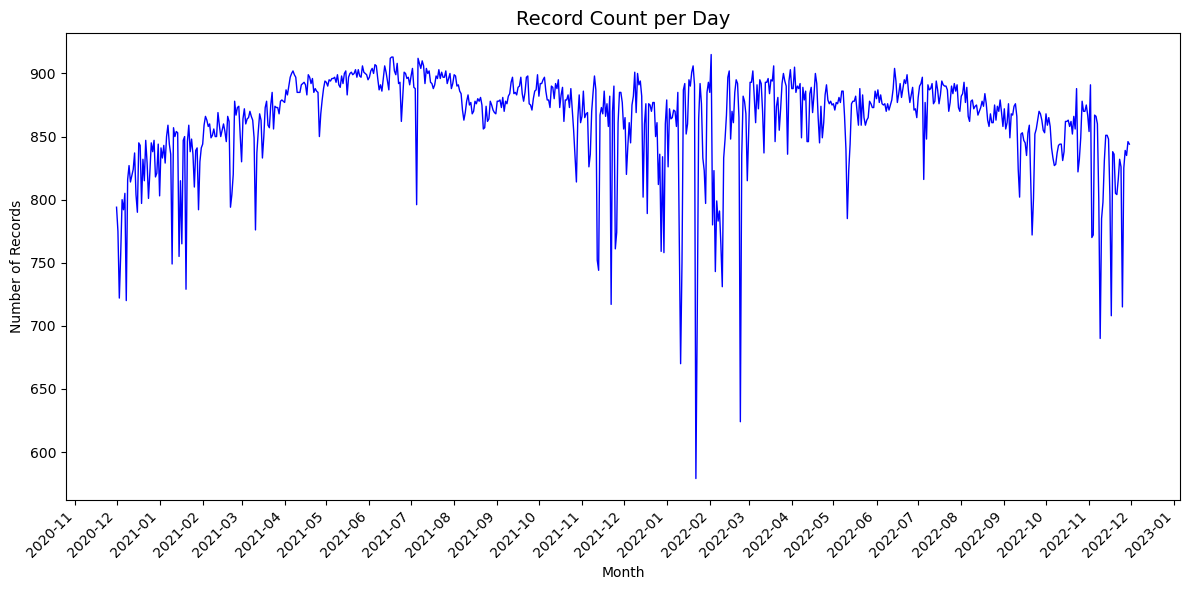

In [181]:
import matplotlib.dates as mdates

df_valid['date'] = pd.to_datetime(
    df_valid['date'],
    format='%Y-%m-%d',
    errors='coerce'
)

date_counts = (
    df_valid
    .groupby('date')
    .size()
    .sort_index()
)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(date_counts.index, date_counts.values, color = 'blue', linewidth = 1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y‑%m'))  
plt.setp(ax.get_xticklabels(), rotation = 45, ha='right')       

ax.set_title("Record Count per Day", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Records")
plt.tight_layout()
plt.show()

# Check sensor distribution on one day

SSLError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /toner-lite/9/86/203.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))

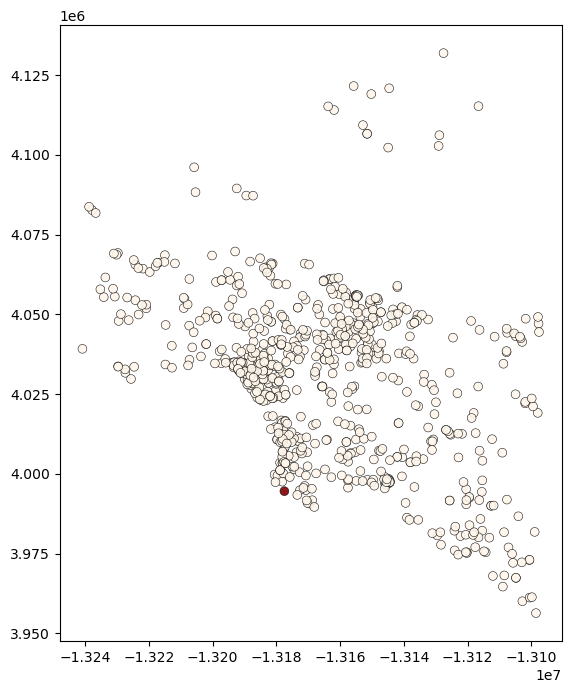

In [193]:
import contextily as cx
import matplotlib as mpl 

purple = gpd.read_file("../Data/Output/Purpleair_pm25_valid.shp")
gdf = purple.loc[purple["date"] == "2021-12-30"].to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))

cmap = plt.cm.OrRd
vmin, vmax = gdf["pm25_avg"].min(), gdf["pm25_avg"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

gdf.plot(
    ax=ax,
    column="pm25_avg",
    cmap=cmap,
    norm=norm,
    markersize=40,        # 适当放大点，方便在底图上看清
    alpha=0.9,
    edgecolor="k",
    linewidth=0.4
)

cx.add_basemap(
    ax,
    crs = gdf.crs,
    source = cx.providers.Stamen.TonerLite,
    attribution = False,
    request_kwargs={"verify": False} 
)

sm = mpl.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cbar = fig.colorbar(sm, ax = ax, shrink = 0.6, pad = 0.02)
cbar.set_label("PurpleAir PM₂.₅ (µg/m³)")

ax.set_axis_off()
plt.tight_layout()
plt.show()